In [1]:
import torch
from SingleSessionSingleTrialDataset import SingleSessionSingleTrialDataset
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090916_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_context_bins = 20 # was equal to 50 for the original demo

n_trials = 2000
datasets = [SingleSessionSingleTrialDataset(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_context_bins=n_context_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Dataset from 2000 trials has 260446 samples


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert dataset to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = []
y = []
for i in range(len(dataset)):
    features, labels = dataset[i]
    X.append(features[:].flatten())
    y.append(labels)
X = torch.stack(X).to(device)
y = torch.stack(y).to(device)

# Split into train/test
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [5]:

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
input_size = n_neurons * n_context_bins
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
).to(device)

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 12

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)
        
        train_r2 = 1 - ((y_train - train_pred)**2).mean() / ((y_train - y_train.mean())**2).mean()
        test_r2 = 1 - ((y_test - test_pred)**2).mean() / ((y_test - y_test.mean())**2).mean()
        
        # Separate R² scores for x and y coordinates
        train_r2_x = 1 - ((y_train[:,0] - train_pred[:,0])**2).mean() / ((y_train[:,0] - y_train[:,0].mean())**2).mean()
        train_r2_y = 1 - ((y_train[:,1] - train_pred[:,1])**2).mean() / ((y_train[:,1] - y_train[:,1].mean())**2).mean()
        test_r2_x = 1 - ((y_test[:,0] - test_pred[:,0])**2).mean() / ((y_test[:,0] - y_test[:,0].mean())**2).mean()
        test_r2_y = 1 - ((y_test[:,1] - test_pred[:,1])**2).mean() / ((y_test[:,1] - y_test[:,1].mean())**2).mean()
    
    if (epoch + 1) % 1 == 0:
        print(f"\nEpoch {epoch+1}/{n_epochs} | Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")
        print(f"\t\tTrain R² (x,y): ({train_r2_x:.3f}, {train_r2_y:.3f}) | Test R² (x,y): ({test_r2_x:.3f}, {test_r2_y:.3f})")



Epoch 1/12 | Train R²: 0.774 | Test R²: 0.739
		Train R² (x,y): (0.832, 0.675) | Test R² (x,y): (0.786, 0.662)

Epoch 2/12 | Train R²: 0.891 | Test R²: 0.862
		Train R² (x,y): (0.921, 0.839) | Test R² (x,y): (0.888, 0.819)

Epoch 3/12 | Train R²: 0.912 | Test R²: 0.884
		Train R² (x,y): (0.932, 0.877) | Test R² (x,y): (0.898, 0.859)

Epoch 4/12 | Train R²: 0.937 | Test R²: 0.908
		Train R² (x,y): (0.952, 0.913) | Test R² (x,y): (0.920, 0.887)

Epoch 5/12 | Train R²: 0.944 | Test R²: 0.913
		Train R² (x,y): (0.959, 0.919) | Test R² (x,y): (0.926, 0.890)

Epoch 6/12 | Train R²: 0.900 | Test R²: 0.858
		Train R² (x,y): (0.909, 0.884) | Test R² (x,y): (0.870, 0.837)

Epoch 7/12 | Train R²: 0.951 | Test R²: 0.917
		Train R² (x,y): (0.965, 0.927) | Test R² (x,y): (0.933, 0.891)

Epoch 8/12 | Train R²: 0.950 | Test R²: 0.912
		Train R² (x,y): (0.967, 0.922) | Test R² (x,y): (0.931, 0.881)

Epoch 9/12 | Train R²: 0.950 | Test R²: 0.910
		Train R² (x,y): (0.954, 0.943) | Test R² (x,y): (0.914,

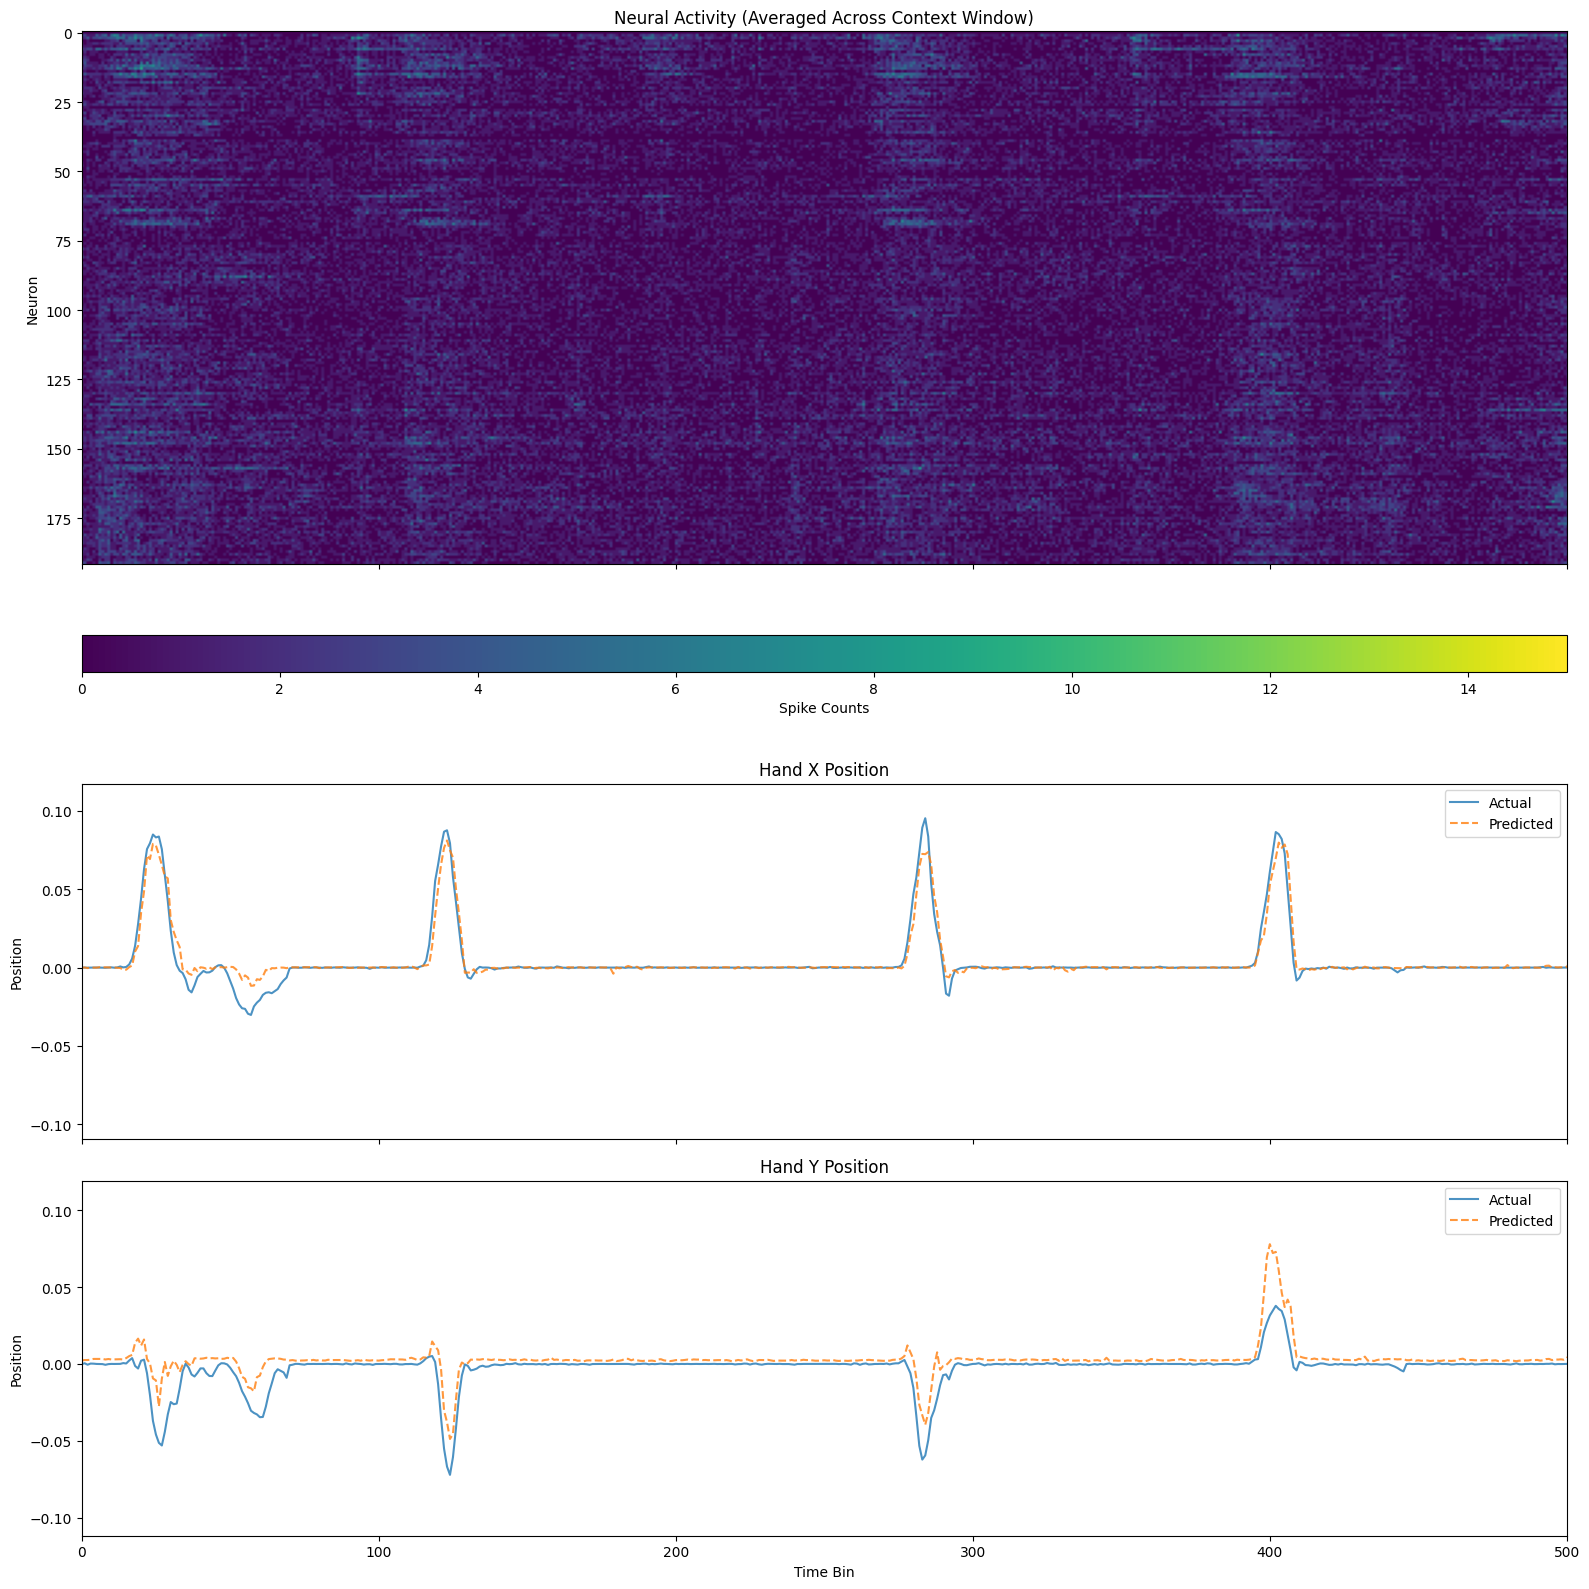

In [4]:
with torch.no_grad():
    test_pred = model(X_test).cpu().numpy()

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16), height_ratios=[2, 1, 1], sharex=True)

# Plot heatmap of X
im = ax1.imshow(X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot x coordinate
ax2.plot(y_test[:, 0], label='Actual', alpha=0.8)
ax2.plot(test_pred[:, 0], label='Predicted', alpha=0.8, linestyle='--')
ax2.set_title('Hand X Position')
ax2.set_ylabel('Position')
ax2.legend()

# Plot y coordinate
ax3.plot(y_test[:, 1], label='Actual', alpha=0.8)
ax3.plot(test_pred[:, 1], label='Predicted', alpha=0.8, linestyle='--')
ax3.set_title('Hand Y Position')
ax3.set_xlabel('Time Bin')
ax3.set_ylabel('Position')
ax3.legend()

limit_time_bins = 500
ax1.set_xlim(0, limit_time_bins)
ax2.set_xlim(0, limit_time_bins)
ax3.set_xlim(0, limit_time_bins)

plt.tight_layout()
plt.show()


In [10]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'trained_mlp_model.pth')


In [21]:
import pygame
import numpy as np
import time

# Initialize Pygame
pygame.init()

# Set up display
WIDTH = 1200
HEIGHT = 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Neural Spike Train Visualization")

# Colors
BLACK = (0, 0, 0)
GRAY = (40, 40, 40)  # For grid lines
WHITE = (255, 255, 255)

# Get spike data
spike_data = X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T
total_bins = spike_data.shape[1]
window_size = 100

# Calculate scaling factors
neuron_height = HEIGHT // n_neurons
time_bin_width = WIDTH // window_size

# Normalize spike data for color intensity
spike_data_normalized = (spike_data - spike_data.min()) / (spike_data.max() - spike_data.min())

# Create font for labels
font = pygame.font.Font(None, 36)

running = True
current_bin = 0
clock = pygame.time.Clock()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
    # Clear screen
    screen.fill(BLACK)
    
    # Draw grid lines
    for i in range(0, HEIGHT, neuron_height * 200):  # Draw every 200 channels
        pygame.draw.line(screen, GRAY, (0, i), (WIDTH, i), 1)
        # Draw channel number
        label = font.render(str(i // neuron_height), True, WHITE)
        screen.blit(label, (10, i))
    
    # Draw spike trains
    if current_bin + window_size <= total_bins:
        for neuron in range(n_neurons):
            for t in range(window_size):
                intensity = int(spike_data_normalized[neuron, current_bin + t] * 255)
                color = (intensity, intensity, intensity)  # White/gray scale
                if intensity > 0:  # Only draw if there's activity
                    pygame.draw.rect(screen, color,
                                   (t * time_bin_width, neuron * neuron_height,
                                    time_bin_width, neuron_height))
    
    # Draw axis labels
    time_label = font.render("Time", True, WHITE)
    channels_label = font.render("Channels", True, WHITE)
    screen.blit(time_label, (WIDTH // 2 - 30, HEIGHT - 30))
    # Rotate and draw y-axis label
    channels_surface = pygame.Surface((200, 30))
    channels_surface.fill(BLACK)
    channels_surface.blit(channels_label, (0, 0))
    channels_surface = pygame.transform.rotate(channels_surface, 90)
    screen.blit(channels_surface, (10, HEIGHT // 2 - 100))
    
    # Update display
    pygame.display.flip()
    
    # Move window
    current_bin += 1
    if current_bin + window_size > total_bins:
        current_bin = 0
        
    # Control frame rate
    clock.tick(20)  # 30 FPS

pygame.quit()


In [ ]:
import pygame
import numpy as np
import time

# Initialize Pygame
pygame.init()

# Set up display
WIDTH = 1200
HEIGHT = 1200  # Increased height to accommodate velocity plots
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Neural Spike Train and Velocity Visualization")

# Colors
BLACK = (0, 0, 0)
GRAY = (40, 40, 40)  # For grid lines
WHITE = (255, 255, 255)
RED = (255, 0, 0)    # For predicted velocity
BLUE = (0, 0, 255)   # For actual velocity

# Get spike data
spike_data = X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T
total_bins = spike_data.shape[1]
window_size = 100

# Calculate scaling factors
spike_view_height = HEIGHT // 2  # Top half for spike trains
neuron_height = spike_view_height // n_neurons
time_bin_width = WIDTH // window_size

# Normalize spike data for color intensity
spike_data_normalized = (spike_data - spike_data.min()) / (spike_data.max() - spike_data.min())

# Get velocity data
y_true = y_test
y_pred = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# Normalize velocity data for plotting
def normalize_for_plot(data, plot_height):
    return (data - data.min()) / (data.max() - data.min()) * plot_height

# Create font for labels
font = pygame.font.Font(None, 36)

running = True
current_bin = 0
clock = pygame.time.Clock()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
    # Clear screen
    screen.fill(BLACK)
    
    # Draw grid lines for spike trains
    for i in range(0, spike_view_height, neuron_height * 200):  # Draw every 200 channels
        pygame.draw.line(screen, GRAY, (0, i), (WIDTH, i), 1)
        # Draw channel number
        label = font.render(str(i // neuron_height), True, WHITE)
        screen.blit(label, (10, i))
    
    # Draw spike trains
    if current_bin + window_size <= total_bins:
        for neuron in range(n_neurons):
            for t in range(window_size):
                intensity = int(spike_data_normalized[neuron, current_bin + t] * 255)
                color = (intensity, intensity, intensity)  # White/gray scale
                if intensity > 0:  # Only draw if there's activity
                    pygame.draw.rect(screen, color,
                                   (t * time_bin_width, neuron * neuron_height,
                                    time_bin_width, neuron_height))
    
    # Draw velocity plots
    plot_height = HEIGHT // 4  # Height for each velocity plot
    y_offset = spike_view_height  # Start below spike trains
    
    # Draw X velocity
    for t in range(window_size - 1):
        if current_bin + t + 1 < len(y_true):
            # True X velocity
            start_y = y_offset + normalize_for_plot(y_true[current_bin + t, 0], plot_height)
            end_y = y_offset + normalize_for_plot(y_true[current_bin + t + 1, 0], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, BLUE, start_pos, end_pos, 2)
            
            # Predicted X velocity
            start_y = y_offset + normalize_for_plot(y_pred[current_bin + t, 0], plot_height)
            end_y = y_offset + normalize_for_plot(y_pred[current_bin + t + 1, 0], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, RED, start_pos, end_pos, 2)
    
    # Draw Y velocity
    y_offset = spike_view_height + plot_height  # Start below X velocity plot
    for t in range(window_size - 1):
        if current_bin + t + 1 < len(y_true):
            # True Y velocity
            start_y = y_offset + normalize_for_plot(y_true[current_bin + t, 1], plot_height)
            end_y = y_offset + normalize_for_plot(y_true[current_bin + t + 1, 1], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, BLUE, start_pos, end_pos, 2)
            
            # Predicted Y velocity
            start_y = y_offset + normalize_for_plot(y_pred[current_bin + t, 1], plot_height)
            end_y = y_offset + normalize_for_plot(y_pred[current_bin + t + 1, 1], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, RED, start_pos, end_pos, 2)
    
    # Draw axis labels
    time_label = font.render("Time", True, WHITE)
    channels_label = font.render("Channels", True, WHITE)
    x_vel_label = font.render("X Velocity (Blue: True, Red: Predicted)", True, WHITE)
    y_vel_label = font.render("Y Velocity (Blue: True, Red: Predicted)", True, WHITE)
    
    screen.blit(time_label, (WIDTH // 2 - 30, HEIGHT - 30))
    screen.blit(x_vel_label, (WIDTH // 2 - 150, spike_view_height + 10))
    screen.blit(y_vel_label, (WIDTH // 2 - 150, spike_view_height + plot_height + 10))
    
    # Rotate and draw y-axis label for spike trains
    channels_surface = pygame.Surface((200, 30))
    channels_surface.fill(BLACK)
    channels_surface.blit(channels_label, (0, 0))
    channels_surface = pygame.transform.rotate(channels_surface, 90)
    screen.blit(channels_surface, (10, spike_view_height // 2 - 100))
    
    # Update display
    pygame.display.flip()
    
    # Move window
    current_bin += 1
    if current_bin + window_size > total_bins:
        current_bin = 0
        
    # Control frame rate
    clock.tick(20)  # 30 FPS

pygame.quit()


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'X_test' is not defined

: 